In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
%matplotlib inline

In [2]:
# NOTE: we're using a single, fixed batch of the first 1000 images
mnist = input_data.read_data_sets( "MNIST_data/", one_hot=True )

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def plot_keep_probability(x_points, 
                          training_points, 
                          test_points, 
                          baseline_points, 
                          title, 
                          label_x, 
                          label_y,
                          label_baseline,
                          label_training,
                          label_test):
    
    plt.figure(figsize=(10,7))
    plt.ylim((0.0,1.0))
    plt.plot(x_points, baseline_points,'r', label=label_baseline)
    plt.plot(x_points, training_points,'b', label=label_training) 
    plt.plot(x_points, test_points,'g', label=label_test) 
    
    plt.title(title)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.legend(loc='upper right')
    
    plt.show()

In [4]:
def dropconnect(connections, keep_probability):
    shape = tf.shape(connections)
    random_matrix = tf.random_uniform(shape, minval=0.0, maxval=1.0)
    ones_matrix = tf.ones(shape)
    zeros_matrix = tf.zeros(shape)
    
    binary_matrix = tf.select(random_matrix <= keep_probability, ones_matrix, zeros_matrix)
    dropconnect_output = tf.mul(binary_matrix, connections)
    return dropconnect_output

In [5]:
def weight_variable(shape):
    initial = tf.truncated_normal( shape, stddev=0.1 )
    return tf.Variable( initial )

def bias_variable(shape):
    initial = tf.constant( 0.1, shape=shape )
    return tf.Variable(initial)

y_ = tf.placeholder( tf.float32, shape=[None, 10], name="y_" )
x = tf.placeholder( tf.float32, shape=[None, 784], name="x" )
kp = tf.placeholder( tf.float32 , name="keep_probability")


W1 = weight_variable([784, 500])
W1 = dropconnect(W1, kp)
b1 = bias_variable([500])
b1 = dropconnect(b1, kp)

h1 = tf.nn.relu( tf.matmul( x, W1 ) + b1 )


W2 = weight_variable([500, 500])
W2 = dropconnect(W2, kp)
b2 = bias_variable([500])
b2 = dropconnect(b2, kp)

h2 = tf.nn.relu( tf.matmul( h1, W2 ) + b2 )


W3 = weight_variable([500, 1000])
W3 = dropconnect(W3, kp)
b3 = bias_variable([1000])
b3 = dropconnect(b3, kp)

h3 = tf.nn.relu( tf.matmul( h2, W3 ) + b3 )


W4 = weight_variable([1000, 10])
b4 = bias_variable([10])
y_hat = tf.nn.softmax(tf.matmul(h3, W4) + b4)


cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_hat), reduction_indices=[1]))
xent_summary = tf.scalar_summary( 'xent', cross_entropy )


correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
acc_summary = tf.scalar_summary( 'accuracy', accuracy )


train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

Starting Round
Starting Round
Starting Round
Starting Round
Starting Round


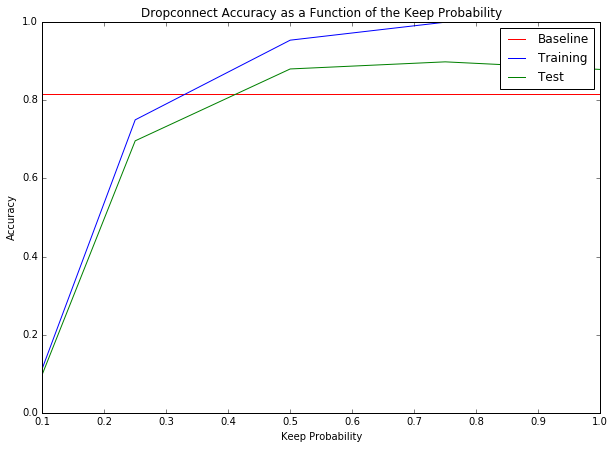

In [6]:
images = mnist.train.images[ 0:1000, : ]
labels = mnist.train.labels[ 0:1000, : ]
keep_probabilities = [ 0.1, 0.25, 0.5, 0.75, 1.0 ]


training_points = np.zeros(5)
test_points = np.zeros(5)
baseline_points = [0.8153] * 5


for i in range(len(keep_probabilities)):
    with tf.Session() as sess:
        keep_probability = keep_probabilities[i]
        sess.run( tf.initialize_all_variables() )
        print("Starting Round") 
        
        for j in range( 1500 ):
            sess.run( [ train_step, accuracy ], feed_dict={ x: images, y_: labels, kp: keep_probability} )

        final_train_acc = sess.run( accuracy, feed_dict={ x: images, y_: labels, kp: 1.0} )
        final_test_acc = sess.run( accuracy, feed_dict={ x: mnist.test.images, y_: mnist.test.labels, kp: 1.0} )

        training_points[i] = final_train_acc
        test_points[i] = final_test_acc

        
plot_keep_probability(x_points = keep_probabilities, 
                      training_points = training_points, 
                      test_points = test_points, 
                      baseline_points = baseline_points, 
                      title = "Dropconnect Accuracy as a Function of the Keep Probability", 
                      label_x = "Keep Probability", 
                      label_y = "Accuracy",
                      label_baseline = "Baseline",
                      label_training = "Training",
                      label_test = "Test")
